# Biolog data analysis

Softare DuctApe was used for analysis of Biolog data

## Ductape pipeline for genome to phenome comparison 

Input and output data for this analysis step in stored in forllowing directory:

data_dir = '../data/biolog'

Reference : http://combogenomics.github.io/DuctApe/howto.html

1. Project setup 

```
dape init -n 'Nissle 1917' -d 'Biolog data and genome correlation for E coli Nissle 1917'
dape add -n "Escherichia coli Nissle 1917" -c red 'Nissle 1917'
```

2. Genome analysis 

Upload fasta files to KEGG annotation server and download kegg.ko file.

List of organisms used for annotation:

eco, ecj, ecd, ebw, ecl, efe, ecz, eci, ecc, ebd, eum, ect, ebr, ecq, ecr, ecy, ecm, ecx, ecv, ecos, ecw, ecg, eck, eoi, stm, sfl, sfx, ssn, sbo, sbc, kpn, ype, yen, spe

```
dgenome add ../input/Nissle_1917.fa 'Nissle 1917'
dgenome add-ko ../input/Nissle_1917.ko
```

> Added 5045 protein to organism Nissle 1917

> Mapped 3339 proteins to KO

3. Start the KEGG mapping and the pangenome construction

```
dgenome start -n 8
dgenome stats
dgenome export
```

> Added 2891 KO IDs

> Added 129 Pathways

> Added 2294 KEGG reactions

> Added 1467 exclusice KEGG reactions

> Added 2110 EC numbers

4. Analyze the growth curves and to map the phenomic compounds to KEGG using dphenome

```
dphenome add ../input/biolog.csv 'Nissle 1917'
dphenome zero
dphenome start -e -f
dphenome start

dphenome plot -s -n 'Plot all plates'
dphenome rings -d 4 -s
dphenome stats -s
dphenome export
```

5. Metabolic network reconstruction step

```
dape map 'Nissle 1917'
dape map
dape start -s
dape export
```

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cobra
import cameo

# 1.1 Create biolog dataframe

In [2]:
# Biolog data output path
output_path = '../data/biolog/output/'

In [3]:
# Create dataframe of biolog data
phenome_combined_path = os.path.join(output_path, 'phenome_Nissle 1917.tsv')
df_biolog_all = pd.read_table(phenome_combined_path, sep='\t', header=0)
index_list = [df_biolog_all.loc[idx, '#plate_id'] + '_' + df_biolog_all.loc[idx, 'well_id'] for idx in df_biolog_all.index]
df_biolog_all['index'] = index_list
df_biolog_all.set_index('index', inplace=True)

phenome_avg_combined_path = os.path.join(output_path, 'phenome_avg_Nissle 1917.tsv')
df_biolog = pd.read_table(phenome_avg_combined_path, sep='\t', header=0)
index_list = [df_biolog.loc[idx, '#plate_id'] + '_' + df_biolog.loc[idx, 'well_id'] for idx in df_biolog.index]
df_biolog['index'] = index_list
df_biolog.set_index('index', inplace=True)

# Ensure that the negative controls are not counted as sources
df_biolog.loc[df_biolog['chemical'] == 'Negative Control', 'moa'] = 'Negative control'
df_biolog.loc[df_biolog['chemical'] == 'Negative Control', 'category'] = 'Negative control'

df_biolog

,#plate_id,well_id,chemical,category,moa,co_id,avg activity
index,,,,,,,
PM01_A01,PM01,A01,Negative Control,Negative control,Negative control,NaN,0.000000
PM01_A02,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,8.000000
PM01_A03,PM01,A03,N-Acetyl-D-Glucosamine,carbon,"C-Source, carbohydrate",C00140,8.000000
PM01_A04,PM01,A04,D-Saccharic acid,carbon,"C-Source, carboxylic acid",C00818,8.666667
PM01_A05,PM01,A05,Succinic acid,carbon,"C-Source, carboxylic acid",C00042,8.666667
...,...,...,...,...,...,...,...
PM05_H08,PM05,H08,Choline,nutrient stimulation,Nutritional supplement,C00114,0.000000
PM05_H09,PM05,H09,Tween 20,nutrient stimulation,Nutritional supplement,C11624,0.333333
PM05_H10,PM05,H10,Tween 40,nutrient stimulation,Nutritional supplement,NaN,0.000000


### 1.2 Generate boolean growth values if AV > growth_cutoff

In [4]:
growth_cutoff = 2 # Low growth at 2, normal growth above 4
df_biolog.loc[:, 'EcNissle_gt3'] = df_biolog.loc[:,'avg activity'] > growth_cutoff
df_biolog.loc[:, 'EcNissle_gt3'] = df_biolog.loc[:,'EcNissle_gt3'].astype(int)
df_biolog.rename(columns={'avg activity': 'EcNissle'}, inplace=True)

### 1.3 Biolog overview

In [5]:
# Get total numbers of C/N/S/P-sources tested
df_moa_all = df_biolog['moa'].value_counts()

# Get the counts per moa  
df_moa = df_biolog.groupby('moa').sum()['EcNissle_gt3']

# Create an overview table
moa_overview_df = pd.DataFrame(columns=['source', 'total', 'growth', 'percentage'])
moa_overview_df.set_index('source', inplace=True)

# Add the information for the 4 sources in general
for source in ['C-Source', 'N-Source', 'S-Source', 'P-Source']:
    moa_overview_df.loc[source, 'total'] = len(df_biolog[df_biolog['moa'].str.contains(source)])
    moa_overview_df.loc[source, 'growth'] = df_moa[df_moa.index.str.contains(source)].sum()
    moa_overview_df.loc[source, 'percentage'] = df_moa[df_moa.index.str.contains(source)].sum() / len(df_biolog[df_biolog['moa'].str.contains(source)])
    
# Add the information for the different catagories
for source in df_moa.index:
    moa_overview_df.loc[source, 'total'] = df_moa_all.loc[source]
    moa_overview_df.loc[source, 'growth'] = df_moa.loc[source]
    moa_overview_df.loc[source, 'percentage'] = df_moa.loc[source] / df_moa_all.loc[source]
    
moa_overview_df

,total,growth,percentage
source,,,
C-Source,190,92,0.484211
N-Source,95,53,0.557895
S-Source,35,27,0.771429
P-Source,59,52,0.881356
"C-Source, alcohol",6,1,0.166667
"C-Source, amide",3,0,0.0
"C-Source, amine",5,0,0.0
"C-Source, amino acid",30,14,0.466667
"C-Source, carbohydrate",71,47,0.661972


In [6]:
# Save csv
moa_path = '../tables/biolog_moa_out.csv'
df_moa.to_csv(moa_path)
biolog_out_path = '../tables/biolog.csv'
df_biolog.to_csv(biolog_out_path)

# 2.1 Compare with model growth

In [7]:
# Load EcN model
EcN_model = cobra.io.load_json_model('../data/models/CP022686.1_cur_4.7.json')

# Import df_biolog when only running this part of notebook
df_biolog = pd.read_csv('../tables/biolog.csv')
df_biolog.set_index('index', inplace = True)

# Add MNXM and BiGG identifiers
biolog_bigg_map = pd.read_csv('../tables/biolog_bigg_map.csv', index_col='index')

df_biolog.loc[biolog_bigg_map.index, 'MNXM'] = biolog_bigg_map['MNXM']
df_biolog.loc[biolog_bigg_map.index, 'bigg'] = biolog_bigg_map['bigg']
df_biolog.loc[biolog_bigg_map.index, 'exchange'] = biolog_bigg_map['exchange']

# Check df
df_biolog.head()

,#plate_id,well_id,chemical,category,moa,co_id,EcNissle,EcNissle_gt3,MNXM,bigg,exchange
index,,,,,,,,,,,
PM01_A01,PM01,A01,Negative Control,Negative control,Negative control,NaN,0.000000,0,#,#,#
PM01_A02,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,8.000000,1,MNXM461,arab__L,EX_arab__L_e
PM01_A03,PM01,A03,N-Acetyl-D-Glucosamine,carbon,"C-Source, carbohydrate",C00140,8.000000,1,MNXM143,acgam,EX_acgam_e
PM01_A04,PM01,A04,D-Saccharic acid,carbon,"C-Source, carboxylic acid",C00818,8.666667,1,MNXM744,glcr,EX_glcr_e
PM01_A05,PM01,A05,Succinic acid,carbon,"C-Source, carboxylic acid",C00042,8.666667,1,MNXM25,succ,EX_succ_e


Biolog media composition was based on Bochner et al. (2001), except that 20 mM sodium pyruvate was used
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC311101/

The complete minimal medium used in the EN, EPS, and EA microplates contained 100 mM NaCl, 30 mM triethanolamine HCl (pH 7.1), 25 mM sodium pyruvate, 5.0 mM NH4Cl, 2.0 mM NaH2PO4, 0.25 mM Na2SO4, 0.05 mM MgCl2, 1.0mM KCl, 1.0 μM ferric chloride, and 0.01% tetrazolium violet. Nitrogen-free, phosphorus-free, and sulfur-free versions of this medium were used in the EN and EPS microplates keeping the same concentrations for nitrogen, phosphorus, and sulfur sources.

In [8]:
def add_model_grwt(PM_data, model_name, model):
    '''
    Function to add model predicted growth rate data
    '''
    Expt_column = model_name
    grwt = model_name+'_model_growth_rate'
    PM_data[grwt] = '#'
    biolog_growth_col = model_name +'_biolog_growth'
    PM_data[biolog_growth_col] = '#'
    model_growth_col = model_name +'_model_growth'
    PM_data[model_growth_col] = '#'
    Prediction = model_name +'_Prediction'
    PM_data[Prediction] = '#'
        
    model_exchanges = model.reactions
    for index in PM_data.index:
        if PM_data.loc[index,Expt_column] > growth_cutoff:
            PM_data.loc[index,biolog_growth_col] = 'Growth'
        else:
            PM_data.loc[index,biolog_growth_col] = 'No Growth'
        
        exrxn = PM_data.loc[index,'exchange']
        if exrxn == '#':
            pass
        else:
            for rxn in model_exchanges:
                if exrxn == rxn.id:
                    with model:
                        # Define the biolog media
                        medium = model.medium
                        medium['EX_glc__D_e'] = 0
                        medium['EX_pyr_e'] = 20
                        medium['EX_nh4_e'] = 5.0
                        medium['EX_pi_e'] = 2.0
                        medium['EX_so4_e'] = 0.25
                        medium['EX_mg2_e'] = 0.05
                        medium['EX_fe3_e'] = 0.001
                        
                        # Change the nutrient
                        if PM_data.loc[index,'category'] == 'carbon':
                            model.medium = medium
                            sol = model.optimize()
                            growth_wt = sol.objective_value
                            medium["EX_pyr_e"] = 0.0
                            medium[exrxn] = 20
                        elif PM_data.loc[index,'category'] == 'nitrogen':
                            model.medium = medium
                            sol = model.optimize()
                            growth_wt = sol.objective_value
                            medium["EX_nh4_e"] = 0.0
                            medium[exrxn] = 5.0
                        elif PM_data.loc[index,'moa'] == 'P-Source, organic':
                            model.medium = medium
                            sol = model.optimize()
                            growth_wt = sol.objective_value
                            medium["EX_pi_e"] = 0.0
                            medium[exrxn] = 2.0
                        elif PM_data.loc[index,'moa'] == 'S-Source, organic':
                            model.medium = medium
                            sol = model.optimize()
                            growth_wt = sol.objective_value
                            medium["EX_so4_e"] = 0.0
                            medium[exrxn] = 0.25
                        
                        # Compare growth
                        model.medium = medium
                        solution = model.optimize()
                        obj = solution.objective_value 
                        if obj > 0.05*growth_wt:
                            PM_data.loc[index,grwt] = obj
                            PM_data.loc[index,model_growth_col] = 'Growth'
                            
                            if PM_data.loc[index,Expt_column] > growth_cutoff:
                                PM_data.loc[index,Prediction] = 'TP'
                            else:
                                PM_data.loc[index,Prediction] = 'FP'
                        else:
                            PM_data.loc[index,grwt] = 0
                            PM_data.loc[index,model_growth_col] = 'No Growth'
                            
                            if PM_data.loc[index,Expt_column] > growth_cutoff:
                                PM_data.loc[index,Prediction] = 'FN'
                            else:
                                PM_data.loc[index,Prediction] = 'TN'                           
    return PM_data

In [9]:
# Run the function & compare biolog data with predictions
PM_data_processed = add_model_grwt(df_biolog, 'EcNissle', EcN_model)
PM_data_processed.head()

# Save csv
PM_data_processed.to_csv('../tables/biolog_comparison.csv')

C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status 

# 2.2 Visualise growth comparison

In [10]:
# plot confusion matrix
def get_confusion_mat(df, pred_col):
    conf_mat = pd.DataFrame(0,index=['Growth','No Growth'],columns=['Growth','No Growth'])
    for index in df.index:
        if df.loc[index,pred_col] == '#':
            pass
        elif df.loc[index,pred_col] == 'TP':
            conf_mat.loc['Growth','Growth'] = conf_mat.loc['Growth','Growth'] + 1
        elif df.loc[index,pred_col] == 'TN':
            conf_mat.loc['No Growth','No Growth'] = conf_mat.loc['No Growth','No Growth'] + 1  
        elif df.loc[index,pred_col] == 'FP':
            conf_mat.loc['No Growth','Growth'] = conf_mat.loc['No Growth','Growth'] + 1
        elif df.loc[index,pred_col] == 'FN':
            conf_mat.loc['Growth','No Growth'] = conf_mat.loc['Growth','No Growth'] + 1    
    return conf_mat

In [11]:
# Get dataframe
conf_mat = get_confusion_mat(PM_data_processed, 'EcNissle_Prediction')
conf_mat

,Growth,No Growth
Growth,115,6
No Growth,26,25


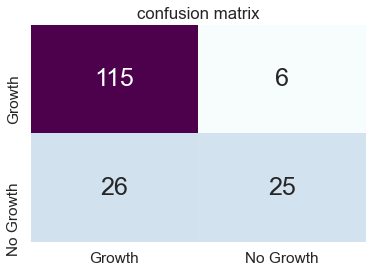

In [12]:
conf_mat = get_confusion_mat(PM_data_processed, 'EcNissle_Prediction')
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_mat, cmap='BuPu',annot=True,annot_kws={"size": 25}, fmt='g', cbar=False)# font size
plt.title('confusion matrix')
# plt.savefig('../conf_mat_EcNissle.svg', type='svg')
plt.show()

# 3.1 Gapfilling false negatives

In [13]:
FN_df = PM_data_processed[PM_data_processed.EcNissle_Prediction == 'FN']
FN_df

,#plate_id,well_id,chemical,category,moa,co_id,EcNissle,EcNissle_gt3,MNXM,bigg,exchange,EcNissle_model_growth_rate,EcNissle_biolog_growth,EcNissle_model_growth,EcNissle_Prediction
index,,,,,,,,,,,,,,,
PM03_B07,PM03,B07,L-Methionine,nitrogen,"N-Source, amino acid",C00073,6.000000,1,MNXM61,met__L,EX_met__L_e,0,Growth,No Growth,FN
PM03_B08,PM03,B08,L-Phenylalanine,nitrogen,"N-Source, amino acid",C00079,6.000000,1,MNXM97,phe__L,EX_phe__L_e,0,Growth,No Growth,FN
PM03_C02,PM03,C02,L-Valine,nitrogen,"N-Source, amino acid",C00183,4.000000,1,MNXM199,val__L,EX_val__L_e,0,Growth,No Growth,FN
PM04_G07,PM04,G07,L-Methionine,phosphate & sulphur,"S-Source, organic",C00073,7.000000,1,MNXM61,met__L,EX_met__L_e,0,Growth,No Growth,FN
PM04_G08,PM04,G08,D-Methionine,phosphate & sulphur,"S-Source, organic",C00855,6.333333,1,MNXM1275,met__D,EX_met__D_e,0,Growth,No Growth,FN
PM04_G11,PM04,G11,L-Methionine Sulfoxide,phosphate & sulphur,"S-Source, organic",C02989,7.000000,1,MNXM2246,metsox_S__L,EX_metsox_S__L_e,0,Growth,No Growth,FN


In [14]:
# load EcN & MG1655 model and create a copy
def gapfilling(model_1, model_2, exchange_df):
    modelCopy = model_1.copy()
    baseCopy = model_2.copy()
    
    # Create a list of reactions to check
    exchange_rxn = exchange_df['exchange'].tolist()
    rxn_dict = {}

    # adjust the carbon source
    for rxn_source in exchange_rxn:
        with modelCopy:
            with baseCopy:

                # Define the media
                for model in [modelCopy, baseCopy]:
#                     medium = model.medium
#                     medium['EX_glc__D_e'] = 0
#                     medium['EX_pyr_e'] = 20
#                     medium['EX_nh4_e'] = 5.0
#                     medium['EX_pi_e'] = 2.0
#                     medium['EX_so4_e'] = 0.25
#                     medium['EX_mg2_e'] = 0.05
#                     medium['EX_fe3_e'] = 0.001
#                     model.medium = medium
                    
                    model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
                    model.reactions.get_by_id('EX_pyr_e').lower_bound = -20
                    model.reactions.get_by_id('EX_nh4_e').lower_bound = -5.0
                    model.reactions.get_by_id('EX_pi_e').lower_bound = -2.0
                    model.reactions.get_by_id('EX_so4_e').lower_bound = -0.25
                    model.reactions.get_by_id('EX_mg2_e').lower_bound = -0.05
                    model.reactions.get_by_id('EX_fe3_e').lower_bound = -0.001
                    model.reactions.get_by_id(rxn_source).lower_bound=-20 # Add the c/n/p/n source tested

                # Adapt the missing source, based on the source
                if exchange_df.loc[exchange_df['exchange'] == rxn_source, 'moa'][0] == 'C-Source, carboxylic acid' and rxn_source != 'EX_pyr_e': #Added [0], since two occurances of Malic acid are in the list
                    modelCopy.reactions.EX_pyr_e.lower_bound=0
                    baseCopy.reactions.EX_pyr_e.lower_bound=0
                elif exchange_df.loc[exchange_df['exchange'] == rxn_source, 'moa'][0] == 'N-Source, amino acid' and rxn_source != 'EX_nh4_e':
                    modelCopy.reactions.EX_nh4_e.lower_bound=0
                    baseCopy.reactions.EX_nh4_e.lower_bound=0
                elif exchange_df.loc[exchange_df['exchange'] == rxn_source, 'moa'][0] == 'P-Source, organic' and rxn_source != 'EX_pi_e':
                    modelCopy.reactions.EX_pi_e.lower_bound=0
                    baseCopy.reactions.EX_pi_e.lower_bound=0
                elif exchange_df.loc[exchange_df['exchange'] == rxn_source, 'moa'][0] == 'S-Source, organic' and rxn_source != 'EX_so4_e':
                    modelCopy.reactions.EX_so4_e.lower_bound=0
                    baseCopy.reactions.EX_so4_e.lower_bound=0
                else:
                    print('error: source not defined')

                # Run gafiller
                gapfiller = cobra.flux_analysis.gapfilling.GapFiller(modelCopy, universal=baseCopy, demand_reactions=False, integer_threshold=1e-12)
                gapfiller.model.solver.configuration.tolerances.feasibility = 1e-16
                gapfiller.model.solver.configuration.tolerances.integrality = 1e-16
                gapfiller.model.solver.configuration.tolerances.optimality = 1e-16
                
                try:
                    result = gapfiller.fill()
                except:
                    print(rxn_source, 'failed')
                    continue

                # save the result in a dictionary
                genes = []
                for result_1 in result:
                    for gene in result_1:
                        genes.append(gene.id)
    #             print(rxn_source, modelCopy.reactions.get_by_id(rxn_source).lower_bound, modelCopy.reactions.get_by_id('EX_glc__D_e').lower_bound, modelCopy.reactions.get_by_id('EX_fru_e').lower_bound)
                rxn_dict[rxn_source] = genes
        
                # reset rxn_source
                for model in [modelCopy, baseCopy]:
                    model.reactions.get_by_id(rxn_source).lower_bound=0 # Add the c/n/p/n source tested
        
    return rxn_dict

In [15]:
# Load reference reactome for gapfilling procedure
# universal = cobra.io.load_json_model('../data/models/iML1515.json')
universal =cobra.io.load_json_model('../data/models/panecoli_universal.json')
# universal =cobra.io.load_json_model('../data/models/universal_model.json')

gapfilling(EcN_model, universal, FN_df)

EX_met__L_e failed
EX_phe__L_e failed
EX_val__L_e failed
EX_met__L_e failed
EX_met__D_e failed
EX_metsox_S__L_e failed


{}

# 4.1 Comparison with MG1655
Use online data from BioCyc for K12. Compare to EcN data

Mackie et al. (2014) Addition of Escherichia coli K-12 Growth Observation and Gene Essentiality Data to the EcoCyc Database 
<br>https://jb.asm.org/content/196/5/982


In [16]:
# Read data from BioCyc
k12_biolog = pd.read_excel('../data/biolog/MG1655_data.xlsx', sheet_name = 'Growth calls summary', header=2, names=['Plate', 'Well No.', 'Compound', 'V1', 'V2'])
k12_biolog = k12_biolog.dropna()
k12_biolog

,Plate,Well No.,Compound,V1,V2
1,PM1,A02,L-arabinose,G,G
2,PM1,A03,N-acetyl-D-glucosamine,LG,G
3,PM1,A04,D-saccharic acid,G,G
4,PM1,A05,succinic acid,G,G
5,PM1,A06,D-galactose,G,G
...,...,...,...,...,...
379,PM4,H08,p-amino benzene sulfonic acid,N,ambiguous
380,PM4,H09,butane sulfonic acid,G,G
381,PM4,H10,2-hydroxyethane sulfonic acid,G,G
382,PM4,H11,methane sulfonic acid,G,G


In [17]:
# Combine the V1 and V2 data set and give only G/N/ambiguous values
for row in k12_biolog.index.tolist():
    # All options for V1 as growth
    if k12_biolog.loc[row, 'V1'] == 'G':
        if k12_biolog.loc[row, 'V2'] == 'G':
            k12_biolog.loc[row, 'V3'] = 'G'
        if k12_biolog.loc[row, 'V2'] == 'N':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'
        if k12_biolog.loc[row, 'V2'] == 'ambiguous':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'
    
    # All options for V1 as low-growth
    if k12_biolog.loc[row, 'V1'] == 'LG':
        if k12_biolog.loc[row, 'V2'] == 'G':
            k12_biolog.loc[row, 'V3'] = 'G'
        if k12_biolog.loc[row, 'V2'] == 'N':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'
        if k12_biolog.loc[row, 'V2'] == 'ambiguous':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'

    # All options for V1 as no-growth
    if k12_biolog.loc[row, 'V1'] == 'N':
        if k12_biolog.loc[row, 'V2'] == 'N':
            k12_biolog.loc[row, 'V3'] = 'N'
        if k12_biolog.loc[row, 'V2'] == 'G':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'
        if k12_biolog.loc[row, 'V2'] == 'ambiguous':
            k12_biolog.loc[row, 'V3'] = 'ambiguous'

    # If V1 is ambiguous       
    if k12_biolog.loc[row, 'V1'] == 'ambiguous':
        k12_biolog.loc[row, 'V3'] = 'ambiguous'

    # If V1 is variable       
    if k12_biolog.loc[row, 'V1'] == 'variable':
        k12_biolog.loc[row, 'V3'] = 'ambiguous'

# Number of ambiguous growth results
print('Number of ambiguous reactions:', len(k12_biolog[k12_biolog['V3'] == 'ambiguous']))
k12_biolog

Number of ambiguous reactions: 39


,Plate,Well No.,Compound,V1,V2,V3
1,PM1,A02,L-arabinose,G,G,G
2,PM1,A03,N-acetyl-D-glucosamine,LG,G,G
3,PM1,A04,D-saccharic acid,G,G,G
4,PM1,A05,succinic acid,G,G,G
5,PM1,A06,D-galactose,G,G,G
...,...,...,...,...,...,...
379,PM4,H08,p-amino benzene sulfonic acid,N,ambiguous,ambiguous
380,PM4,H09,butane sulfonic acid,G,G,G
381,PM4,H10,2-hydroxyethane sulfonic acid,G,G,G
382,PM4,H11,methane sulfonic acid,G,G,G


In [18]:
# Create index that is similar to EcN biolog df
k12_biolog['index'] = 'PM0' + k12_biolog['Plate'].str[-1] + '_' + k12_biolog['Well No.']
k12_biolog.set_index('index', inplace=True)

# Remove ambiguous data points & convert to 0/1
k12_biolog = k12_biolog[k12_biolog['V3'] != 'ambiguous']
k12_biolog['V3'] = k12_biolog['V3'].map(lambda x: 1 if x is 'G' else 0)

print('Total number of sources that can be compared is', len(k12_biolog))
k12_biolog.head()

C:\Users\maxvan\AppData\Local\Continuum\anaconda3\envs\EcN_model\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Total number of sources that can be compared is 340


,Plate,Well No.,Compound,V1,V2,V3
index,,,,,,
PM01_A02,PM1,A02,L-arabinose,G,G,1
PM01_A03,PM1,A03,N-acetyl-D-glucosamine,LG,G,1
PM01_A04,PM1,A04,D-saccharic acid,G,G,1
PM01_A05,PM1,A05,succinic acid,G,G,1
PM01_A06,PM1,A06,D-galactose,G,G,1


In [19]:
# Merge the EcN and K12 biolog dataframes for comparison
comparison_df = pd.merge(df_biolog, k12_biolog, left_index=True, right_index=True)

# Substract one from the other to obtain a column with the difference between the two growth profiles. 
comparison_df['difference'] = comparison_df['EcNissle_gt3'] - comparison_df['V3']

# Add one to the other to obtain a column with the difference between the two growth profiles. 
comparison_df['shared'] = comparison_df['EcNissle_gt3'] + comparison_df['V3']

# Find the number of cases in common
print('The number of cases in common is:', len(comparison_df[comparison_df['difference'] == 0]))
print('Both grew on:', len(comparison_df[comparison_df['shared'] == 2]))
print('Neither grew on:', len(comparison_df[comparison_df['shared'] == 0]))

# Get an overview of the dataframe
comparison_df['category'].value_counts()
# comparison_df['moa'].value_counts()

The number of cases in common is: 308
Both grew on: 184
Neither grew on: 124


carbon                 184
nitrogen                80
phosphate & sulphur     76
Name: category, dtype: int64

### 4.2 EcN growth

In [20]:
# Create a dataframe with nutrients only EcN grows on and one only K12 grows on
EcN_growth = comparison_df[comparison_df['difference'] == 1]
k12_growth = comparison_df[comparison_df['difference'] == -1]

# Save both tables
EcN_growth.to_csv('../tables/biolog_EcN_specific.csv')
k12_growth.to_csv('../tables/biolog_k12_specific.csv')

EcN_growth

,#plate_id,well_id,chemical,category,moa,co_id,EcNissle,EcNissle_gt3,MNXM,bigg,...,EcNissle_model_growth,EcNissle_Prediction,Plate,Well No.,Compound,V1,V2,V3,difference,shared
index,,,,,,,,,,,,,,,,,,,,,
PM01_A12,PM01,A12,Dulcitol,carbon,"C-Source, carbohydrate",C01697,6.000000,1,MNXM1233,galt,...,Growth,TP,PM1,A12,dulcitol,N,N,0,1,1
PM01_D05,PM01,D05,Tween 40,carbon,"C-Source, fatty acid",NaN,3.666667,1,#,MNXM88334,...,#,#,PM1,D05,Tween 40,N,N,0,1,1
PM01_E09,PM01,E09,Adonitol,carbon,"C-Source, carbohydrate",C00474,5.000000,1,MNXM1820,rbt,...,#,#,PM1,E09,adonitol,N,N,0,1,1
PM01_H05,PM01,H05,D-Psicose,carbon,"C-Source, carbohydrate",C06468,4.000000,1,MNXM8509,#,...,#,#,PM1,H05,D-psicose,N,N,0,1,1
PM02_A12,PM02,A12,Pectin,carbon,"C-Source, polymer",C00714,6.000000,1,MNXM107600,pectin,...,#,#,PM2,A12,pectin,N,N,0,1,1
PM02_B01,PM02,B01,N-Acetyl-D-Galactosamine,carbon,"C-Source, carbohydrate",C01074,8.000000,1,MNXM164782,acgal,...,Growth,TP,PM2,B01,N-acetyl-D-galactosamine,N,N,0,1,1
PM02_B05,PM02,B05,D-Arabinose,carbon,"C-Source, carbohydrate",C00216,4.000000,1,MNXM544,arab__D,...,#,#,PM2,B05,D-arabinose,N,N,0,1,1
PM02_B09,PM02,B09,2-Deoxy-D-Ribose,carbon,"C-Source, carbohydrate",C01801,7.333333,1,MNXM90412,drib,...,#,#,PM2,B09,2-deoxy-D-ribose,N,N,0,1,1
PM02_C03,PM02,C03,D-Lactitol,carbon,"C-Source, carbohydrate",NaN,7.000000,1,#,#,...,#,#,PM2,C03,lactitol,N,N,0,1,1


In [21]:
# Number of sources EcN grows on
EcN_growth['category'].value_counts()

carbon                 13
nitrogen                9
phosphate & sulphur     2
Name: category, dtype: int64

In [22]:
# Number of sources EcN grows on - per catagory
EcN_growth['moa'].value_counts()

C-Source, carbohydrate       10
N-Source, other               5
N-Source, amino acid          4
C-Source, polymer             1
C-Source, fatty acid          1
P-Source, inorganic           1
P-Source, organic             1
C-Source, carboxylic acid     1
Name: moa, dtype: int64

### 4.3 K12 growth

In [23]:
k12_growth

,#plate_id,well_id,chemical,category,moa,co_id,EcNissle,EcNissle_gt3,MNXM,bigg,...,EcNissle_model_growth,EcNissle_Prediction,Plate,Well No.,Compound,V1,V2,V3,difference,shared
index,,,,,,,,,,,,,,,,,,,,,
PM01_D07,PM01,D07,a-Ketobutyric acid,carbon,"C-Source, carboxylic acid",C00109,1.666667,0,MNXM159,2obut,...,#,#,PM1,D07,α-keto-butyric acid,G,G,1,-1,1
PM01_E02,PM01,E02,m-Tartaric acid,carbon,"C-Source, carboxylic acid",C00552,0.000000,0,MNXM1031,tartr__M,...,#,#,PM1,E02,m-tartaric acid,G,G,1,-1,1
PM01_G09,PM01,G09,Mono-Methylsuccinate,carbon,"C-Source, carboxylic acid",NaN,1.333333,0,#,methsucc,...,#,#,PM1,G09,mono methyl-succinate,G,G,1,-1,1
PM02_E12,PM02,E12,5-Keto-D-Gluconic acid,carbon,"C-Source, carboxylic acid",C01062,0.000000,0,MNXM963,5dglcn,...,No Growth,TN,PM2,E12,5-keto-D-gluconic acid,G,G,1,-1,1
PM03_F07,PM03,F07,Guanosine,nitrogen,"N-Source, other",C00387,0.333333,0,MNXM401,gsn,...,Growth,FP,PM3,F07,guanosine,LG,G,1,-1,1
PM03_G11,PM03,G11,d-Amino-N-Valeric acid,nitrogen,"N-Source, other",C00431,0.000000,0,MNXM792,5aptn,...,#,#,PM3,G11,amino-N-valeric acid,G,G,1,-1,1
PM04_C05,PM04,C05,2-Deoxy-D-Glucose 6-Phosphate,phosphate & sulphur,"P-Source, organic",C06369,0.000000,0,MNXM3809,2doxg6p,...,#,#,PM4,C05,2-deoxy-D-glucose 6-phosphate,G,G,1,-1,1
PM04_C09,PM04,C09,Cytidine 3`-Monophosphate,phosphate & sulphur,"P-Source, organic",C05822,0.000000,0,#,#,...,#,#,PM4,C09,cytidine-3-monophosphate,G,G,1,-1,1


In [24]:
# Number of sources K12 grows on - per catagory
k12_growth['moa'].value_counts()

C-Source, carboxylic acid    4
N-Source, other              2
P-Source, organic            2
Name: moa, dtype: int64

# 5. Create Venn diagrams

In [25]:
#Import libraries
import matplotlib
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
%matplotlib inline

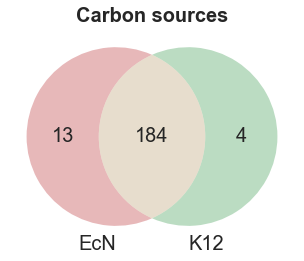

In [26]:
# Carbon
c_total = len(comparison_df[comparison_df['moa'].str.contains('C-Source')])
c_EcN = len(EcN_growth[EcN_growth['moa'].str.contains('C-Source')])
c_k12 = len(k12_growth[k12_growth['moa'].str.contains('C-Source')])
c_diff = c_total - c_EcN - c_k12

# c_k12_set = set(k12_growth[k12_growth['moa'].str.contains('C-Source')]['chemical'].values)

# Plot figure
vd2 = venn2_unweighted(subsets = (c_EcN, c_k12, c_total), set_labels = ('EcN', 'K12'))
plt.title('Carbon sources', fontweight='bold',fontsize=20,)

for text in vd2.set_labels:  #change number size
     text.set_fontsize(20)
for text in vd2.subset_labels:  #change number size
     text.set_fontsize(20)

# Save figure
plt.savefig('../figures/carbon_venn.png')

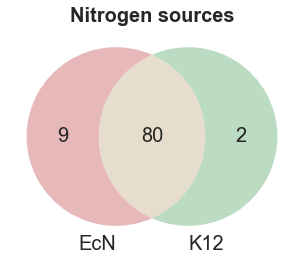

In [27]:
# Nitrogen
c_total = len(comparison_df[comparison_df['moa'].str.contains('N-Source')])
c_EcN = len(EcN_growth[EcN_growth['moa'].str.contains('N-Source')])
c_k12 = len(k12_growth[k12_growth['moa'].str.contains('N-Source')])
c_diff = c_total - c_EcN - c_k12

# Plot figure
vd2 = venn2_unweighted(subsets = (c_EcN, c_k12, c_total), set_labels = ('EcN', 'K12'))
plt.title('Nitrogen sources', fontweight='bold',fontsize=20,)

for text in vd2.set_labels:  #change number size
     text.set_fontsize(20)
for text in vd2.subset_labels:  #change number size
     text.set_fontsize(20)
        
# Save figure
plt.savefig('../figures/nitrogen_venn.png')

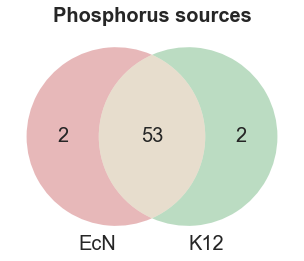

In [28]:
# Phosphorus
c_total = len(comparison_df[comparison_df['moa'].str.contains('P-Source')])
c_EcN = len(EcN_growth[EcN_growth['moa'].str.contains('P-Source')])
c_k12 = len(k12_growth[k12_growth['moa'].str.contains('P-Source')])
c_diff = c_total - c_EcN - c_k12

# Plot figure
vd2 = venn2_unweighted(subsets = (c_EcN, c_k12, c_total), set_labels = ('EcN', 'K12'))
plt.title('Phosphorus sources', fontweight='bold',fontsize=20,)

for text in vd2.set_labels:  #change number size
     text.set_fontsize(20)
for text in vd2.subset_labels:  #change number size
     text.set_fontsize(20)

# Save figure
plt.savefig('../figures/phosphorus_venn.png')

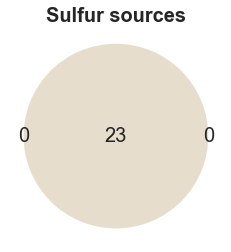

In [29]:
# Sulfur
c_total = len(comparison_df[comparison_df['moa'].str.contains('S-Source')])
c_EcN = len(EcN_growth[EcN_growth['moa'].str.contains('S-Source')])
c_k12 = len(k12_growth[k12_growth['moa'].str.contains('S-Source')])
c_diff = c_total - c_EcN - c_k12

# Plot figure
vd2 = venn2(subsets = (c_EcN, c_k12, c_total), set_labels = ('', ''))
plt.title('Sulfur sources', fontweight='bold',fontsize=20,)

for text in vd2.set_labels:  #change number size
     text.set_fontsize(20)
for text in vd2.subset_labels:  #change number size
     text.set_fontsize(20)      

# Save figure
plt.savefig('../figures/sulfur_venn.png')